### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import randint,uniform
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split, GridSearchCV, KFold,RandomizedSearchCV,cross_validate,cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import StackingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.inspection import permutation_importance
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report,roc_curve, roc_auc_score, RocCurveDisplay


### Load Dataset

In [2]:
breast_cancer_wisconsin_diagnostic = fetch_ucirepo(id=17)

# Combine features and target
df = pd.concat(
    [breast_cancer_wisconsin_diagnostic.data.features,
     breast_cancer_wisconsin_diagnostic.data.targets],
    axis=1
)

target_col = df.columns[-1]
print("The Target Column is:", target_col)

X = df.drop(columns=target_col)
y = df[target_col]

print("\nData shape:", X.shape)
print("Target distribution:\n", y.value_counts())

The Target Column is: Diagnosis

Data shape: (569, 30)
Target distribution:
 Diagnosis
B    357
M    212
Name: count, dtype: int64


### Train-Test Split

In [3]:
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.125, stratify=y_temp, random_state=42
)
# Now train=70%, val=10%, test=20%
print("\nTrain size:", X_train.shape, "Val size:", X_val.shape, "Test size:", X_test.shape)


Train size: (398, 30) Val size: (57, 30) Test size: (114, 30)


### Preprocessing

In [4]:
num_features = X.select_dtypes(include=["int64", "float64"]).columns
cat_features = X.select_dtypes(include=["object"]).columns  

preprocessor = ColumnTransformer([
    ("num", Pipeline([
        ("imputer", SimpleImputer(strategy="mean")),
        ("scaler", StandardScaler())
    ]), num_features),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_features)
])


### Pipeline

In [5]:
svm = ("svm", SVC())
nb = ("nb", GaussianNB())
dt = ("dt", DecisionTreeClassifier())
knn = ("knn", KNeighborsClassifier())

log_reg = LogisticRegression()
rf = RandomForestClassifier()

stack_configs = [
    ([(svm), (nb), (dt)], log_reg, "SVM, NB, DT + Logistic Regression"),
    ([(svm), (nb), (dt)], rf, "SVM, NB, DT + Random Forest"),
    ([(svm), (dt), (knn)], log_reg, "SVM, DT, KNN + Logistic Regression")
]


### Hyperparameter Tuning with GridSearchCV

In [6]:
results = []
kf = KFold(n_splits=5, shuffle=True)
for base_models, final_estimator, label in stack_configs:
    stack = Pipeline([
        ("preprocessor", preprocessor),
        ("clf", StackingClassifier(
            estimators=base_models,
            final_estimator=final_estimator,
            cv=5,
            n_jobs=-1
        ))
    ])
    
    acc_scores = cross_val_score(stack, X, y, cv=kf, scoring="accuracy")
    f1_scores = cross_val_score(stack, X, y, cv=kf, scoring="f1_weighted")
    
    results.append({
        "Label": label,
        "Accuracy Mean": np.mean(acc_scores),
        "F1 Mean": np.mean(f1_scores),
        "Accuracy Scores": acc_scores,
        "F1 Scores": f1_scores,
        "Model": stack
    })
df_results = pd.DataFrame(results)[["Label", "Accuracy Mean", "F1 Mean","Model"]]
print(df_results)
best_model = df_results.loc[df_results["Accuracy Mean"].idxmax()]["Model"]


                                Label  Accuracy Mean   F1 Mean  \
0   SVM, NB, DT + Logistic Regression       0.973638  0.968318   
1         SVM, NB, DT + Random Forest       0.966620  0.971776   
2  SVM, DT, KNN + Logistic Regression       0.980686  0.975229   

                                               Model  
0  (ColumnTransformer(transformers=[('num',\n    ...  
1  (ColumnTransformer(transformers=[('num',\n    ...  
2  (ColumnTransformer(transformers=[('num',\n    ...  


### Cross Validation

In [7]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)

cv_results = cross_validate(
    best_model, X_train, y_train,
    cv=cv,
    scoring=["accuracy", "f1_weighted"],
    n_jobs=-1,
    return_train_score=False
)

print("\n--- 5-Fold Cross Validation on Best Model ---")
for i, (acc, f1) in enumerate(zip(cv_results["test_accuracy"], cv_results["test_f1_weighted"]), 1):
    print(f"Fold {i}: Accuracy = {acc:.4f}, F1 = {f1:.4f}")

print("\nMean Accuracy:", cv_results["test_accuracy"].mean())
print("Mean F1:", cv_results["test_f1_weighted"].mean())


--- 5-Fold Cross Validation on Best Model ---
Fold 1: Accuracy = 0.9875, F1 = 0.9875
Fold 2: Accuracy = 0.9500, F1 = 0.9496
Fold 3: Accuracy = 0.9875, F1 = 0.9875
Fold 4: Accuracy = 0.9494, F1 = 0.9496
Fold 5: Accuracy = 0.9620, F1 = 0.9614

Mean Accuracy: 0.9672784810126581
Mean F1: 0.9671277193071539


### Model Results

In [8]:
best_model.fit(X_train, y_train)
model = best_model
preds = model.predict(X_val)
print(f"\n--- Validation Results ---")
print("Accuracy:", accuracy_score(y_val, preds))
print("Precision:", precision_score(y_val, preds, average="weighted"))
print("Recall:", recall_score(y_val, preds, average="weighted"))
print("F1:", f1_score(y_val, preds, average="weighted"))
print("Confusion Matrix:\n", confusion_matrix(y_val, preds))


--- Validation Results ---
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1: 1.0
Confusion Matrix:
 [[36  0]
 [ 0 21]]


### Test Evaluation

In [9]:
final_model =  best_model
test_preds = final_model.predict(X_test)

print("\n===== Final Test Results =====")
print("Accuracy:", accuracy_score(y_test, test_preds))
print("Precision:", precision_score(y_test, test_preds, average="weighted"))
print("Recall:", recall_score(y_test, test_preds, average="weighted"))
print("F1:", f1_score(y_test, test_preds, average="weighted"))
print("Confusion Matrix:\n", confusion_matrix(y_test, test_preds))
print("\nClassification Report:\n", classification_report(y_test, test_preds))


===== Final Test Results =====
Accuracy: 0.9649122807017544
Precision: 0.9651849217638692
Recall: 0.9649122807017544
F1: 0.9647247085304307
Confusion Matrix:
 [[71  1]
 [ 3 39]]

Classification Report:
               precision    recall  f1-score   support

           B       0.96      0.99      0.97        72
           M       0.97      0.93      0.95        42

    accuracy                           0.96       114
   macro avg       0.97      0.96      0.96       114
weighted avg       0.97      0.96      0.96       114



### Visualization

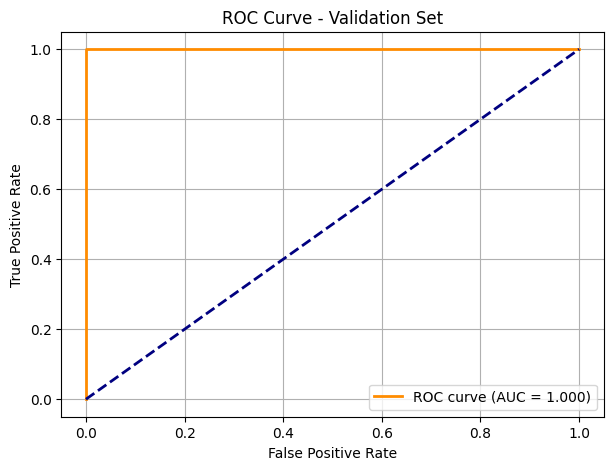

In [10]:
y_val_proba = model.predict_proba(X_val)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_val, y_val_proba, pos_label="M")
roc_auc = roc_auc_score(y_val, y_val_proba)

# Plot ROC Curve
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Validation Set")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

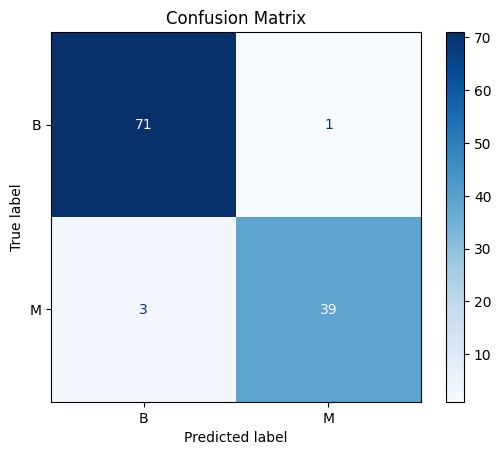

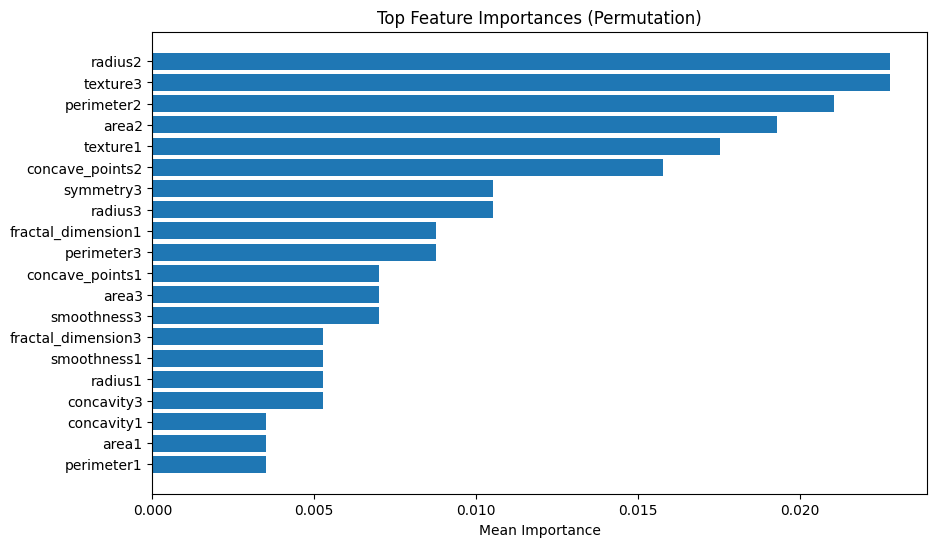

In [11]:
y_pred = best_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred, labels=best_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

best_model.fit(X_train, y_train)

# 🔹 Access the fitted ColumnTransformer (inside pipeline after fit)
preprocessor_fitted = None
for step_name, step in best_model.named_steps.items():
    if isinstance(step, ColumnTransformer):
        preprocessor_fitted = step
        break

if preprocessor_fitted is None:
    raise ValueError("No ColumnTransformer found inside best_model pipeline!")

# 🔹 Now get feature names safely
num_feature_names = list(num_features)
cat_encoder = preprocessor_fitted.named_transformers_["cat"]

# ✅ Make sure encoder is fitted by transforming once
cat_encoder.fit(X[cat_features])

cat_feature_names = list(cat_encoder.get_feature_names_out(cat_features))
feature_names = num_feature_names + list(cat_feature_names)

# 🔹 Permutation importance
r = permutation_importance(best_model, X_val, y_val,
                           n_repeats=10, random_state=42, n_jobs=-1)

# 🔹 Plot top features
sorted_idx = r.importances_mean.argsort()[::-1][:20]
plt.figure(figsize=(10, 6))
plt.barh([feature_names[i] for i in sorted_idx], r.importances_mean[sorted_idx])
plt.gca().invert_yaxis()
plt.title("Top Feature Importances (Permutation)")
plt.xlabel("Mean Importance")
plt.show()